## Import libraries

In [170]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from datetime import datetime
from ast import literal_eval
import re
import numpy as np

## Set directories

In [171]:
abspath_curr = os.path.join(os.getcwd())
data_path = os.path.join(abspath_curr, 'data')

## Read in dataframes and concatenate them

In [172]:
def stitch_frames(data_path):
    frames = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            if subdir.endswith('hashtags_run') and file.endswith('tweets.csv'):
                path = os.path.join(subdir, file)
                df = pd.read_csv(path, index_col=None, header=0)
                frames.append(df)
    df = pd.concat(frames, axis=0, ignore_index=True)
    return df

## Create wordcloud

In [173]:
def create_wc(df):
    
    # Set saving paths
    image_path = os.path.join(abspath_curr, 'images')
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    tweet_text_path = os.path.join(image_path, to_csv_timestamp + 'clean_streaming_text_wordcloud.png')
    hashtag_text_path = os.path.join(image_path, to_csv_timestamp + 'clean_streaming_hashtag_wordcloud.png')
    
    # Get string of all text
    tweet_text = " ".join(text for text in df.text)
    
    # Get string of all hashtags
    hashtags_df = df[['hashtags_text']]
    hashtags_df.hashtags_text = hashtags_df.hashtags_text.replace('nan', np.nan)
    hashtags_df = hashtags_df.dropna()
    hashtag_text = " ".join(hashtag for hashtag in hashtags_df.hashtags_text)
    
    # Generate wordcloud image
    stopwords = set(STOPWORDS)
    tweet_wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(tweet_text)
    hashtag_wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(hashtag_text)

    # Display wordcloud images
    plt.figure(figsize=[10,10])
    plt.title('Tweet Text Wordcloud')
    plt.imshow(tweet_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.savefig(tweet_text_path, format="png")
    
    plt.figure(figsize=[10,10])
    plt.title('Hashtag Wordcloud')
    plt.imshow(hashtag_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.savefig(hashtag_text_path, format='png')
    return

## Plot sentiment

In [174]:
def sentiment_hist(df):

    # Create plot
    sns.set_theme(style="darkgrid")
    sns.histplot(data=df, x="sentiment", bins=75, hue='pos_neg')
    plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
    plt.figure(figsize=[10,10])
    
    # Save image
    image_path = os.path.join(abspath_curr, 'images')
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    image_file_path = os.path.join(image_path, to_csv_timestamp + 'clean_hashtag_streaming_sentiment.png')
    plt.savefig(image_file_path, format="png")
    
    return 

## Clean the data and save

In [175]:
def clean_data():
    
    # Put the data together
    df = stitch_frames(data_path)
    
    # Remove duplicates
    original_shape = df.shape[0]
    df = df.drop_duplicates(subset='tweet_id')
    print(f'Removed {original_shape - len(df)} duplicate tweets.')
    
    # Remove emojis
    df[['user_name', 'screen_name', 'text']] = df[['user_name', 'screen_name', 'text']].astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    
    # Remove urls from text column
    df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

    # Extract coordinates from place column and add to dataframe
    place_series = df.place[pd.isnull(df.place) == False]
    def create_coords(x):
        y = x.split('coordinates=[[')[1].split(']])')[0].replace('[', '').replace(']', '').replace(',', '').split()
        return [[float(y[i]), float(y[i+1])] for i in range(0, len(y), 2)]
    coords = place_series.apply(lambda x: create_coords(x))
    df['coordinates'] = coords

    # Add sentiment column
    df['sentiment'] = df.text.apply(lambda x: TextBlob(x).sentiment[0])

    # Add sentiment pos/neg column
    df['pos_neg'] = df.sentiment.apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

    # Create datetimes
    df.created_at = pd.to_datetime(df.created_at)
    
    if 'entities' in df.columns.tolist():
        df.entities = df.entities.astype(str).apply(literal_eval)
        df = pd.json_normalize(df.to_dict(orient='records'))
        df.columns = df.columns.str.replace('entities.', '')
        df = df.explode(['hashtags']).reset_index(drop=True)
        df = df.explode('urls').reset_index(drop=True)
        df = pd.json_normalize(df.to_dict(orient='records'), sep='_').drop(columns=['hashtags', 'urls'])
    
    # Strip whitespace
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    df[obj_cols] = df[obj_cols].astype(str)
    df[obj_cols] = df[obj_cols].apply(lambda x: x.str.strip())

    # Write to directory
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    file_name = os.path.join(data_path, to_csv_timestamp + 'clean_streaming_hashtags_data.csv')
    df.to_csv(file_name, encoding='utf-8-sig')
    
    # Create wordcloud
    create_wc(df)
    
    # Create sentiment histogram
    sentiment_hist(df)
    
    return df

Removed 3 duplicate tweets.


C:\Users\raide\AppData\Local\Temp/ipykernel_30552/2805587213.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('entities.', '')
C:\JupyterLab\resources\jlab_server\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


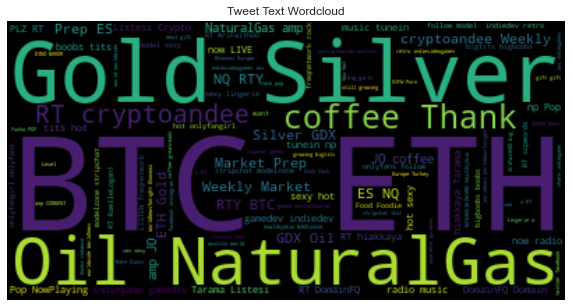

<Figure size 432x288 with 0 Axes>

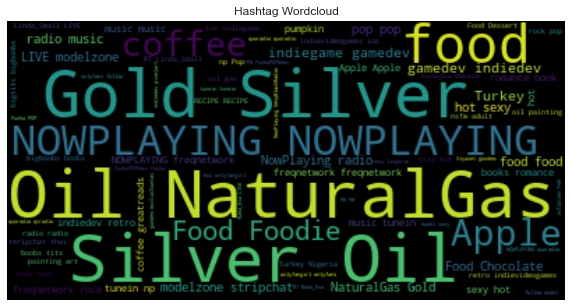

,created_at,tweet_id,user_id,user_name,screen_name,verified,text,quote_tweet,rewteet_count,favorite_count,...,pos_neg,user_mentions,symbols,media,urls_url,urls_expanded_url,urls_display_url,urls_indices,hashtags_text,hashtags_indices
0,2021-10-20 12:40:58+00:00,1450804231376617478,1234709075750866944,Bombaywala Sweets & Namkeens,bombaywalangp,False,Some people live to eat and some people are bo...,False,0,0,...,positive,[],[],nan,https://t.co/zMoF52ImWC,https://twitter.com/i/web/status/1450804231376...,twitter.com/i/web/status/1…,"[117, 140]",nan,nan
1,2021-10-20 12:41:01+00:00,1450804246459424768,346122813,Karl Garratty,KarlGarratty,False,Correct way to make a lasagna? #chef #lasagna ...,False,0,0,...,neutral,[],[],nan,nan,nan,nan,nan,chef,"[32, 37]"
2,2021-10-20 12:41:01+00:00,1450804246459424768,346122813,Karl Garratty,KarlGarratty,False,Correct way to make a lasagna? #chef #lasagna ...,False,0,0,...,neutral,[],[],nan,nan,nan,nan,nan,lasagna,"[38, 46]"
3,2021-10-20 12:41:01+00:00,1450804246459424768,346122813,Karl Garratty,KarlGarratty,False,Correct way to make a lasagna? #chef #lasagna ...,False,0,0,...,neutral,[],[],nan,nan,nan,nan,nan,garfield,"[47, 56]"
4,2021-10-20 12:41:03+00:00,1450804254210510851,1509465397,lap lap,laplapv3,False,"RT @FunnybunnyQ: Wow, just wow!\nDear Little P...",False,0,0,...,positive,"[{'screen_name': 'FunnybunnyQ', 'name': 'Moniq...",[],nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149250,2021-10-21 12:41:04+00:00,1451166648057012233,1643123766,Umair,akbarth3great,False,#covid19 #tests #news #gear #apple Apple will ...,False,0,0,...,neutral,[],[],nan,https://t.co/qZ07sByWhk,http://dlvr.it/SB1bY8,dlvr.it/SB1bY8,"[115, 138]",covid19,"[0, 8]"
149251,2021-10-21 12:41:04+00:00,1451166648057012233,1643123766,Umair,akbarth3great,False,#covid19 #tests #news #gear #apple Apple will ...,False,0,0,...,neutral,[],[],nan,https://t.co/qZ07sByWhk,http://dlvr.it/SB1bY8,dlvr.it/SB1bY8,"[115, 138]",tests,"[9, 15]"
149252,2021-10-21 12:41:04+00:00,1451166648057012233,1643123766,Umair,akbarth3great,False,#covid19 #tests #news #gear #apple Apple will ...,False,0,0,...,neutral,[],[],nan,https://t.co/qZ07sByWhk,http://dlvr.it/SB1bY8,dlvr.it/SB1bY8,"[115, 138]",news,"[16, 21]"
149253,2021-10-21 12:41:04+00:00,1451166648057012233,1643123766,Umair,akbarth3great,False,#covid19 #tests #news #gear #apple Apple will ...,False,0,0,...,neutral,[],[],nan,https://t.co/qZ07sByWhk,http://dlvr.it/SB1bY8,dlvr.it/SB1bY8,"[115, 138]",gear,"[22, 27]"


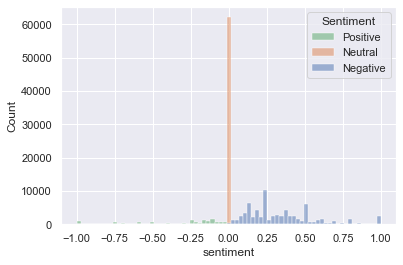

<Figure size 720x720 with 0 Axes>

In [176]:
df = clean_data()
df